In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install zhon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
import re
from zhon.hanzi import punctuation
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
print(tf.__version__)

2.11.0


In [45]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [9]:
fig_path = '/content/drive/MyDrive/ML/Tweet/figs'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

In [10]:
train = pd.read_csv('/content/drive/MyDrive/ML/Tweet/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ML/Tweet/tweet-sentiment-extraction/test.csv')

In [11]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [12]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [13]:
print(train.shape, test.shape)
train.describe()
uni_senti = train['sentiment'].unique()
print(uni_senti)

(27481, 4) (3534, 3)
['neutral' 'negative' 'positive']


In [14]:
# check null data in train
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [15]:
# drop the null value
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [16]:
# do some plotting
num_senti = train.groupby('sentiment').count()
print(num_senti)

           textID   text  selected_text
sentiment                              
negative     7781   7781           7781
neutral     11117  11117          11117
positive     8582   8582           8582


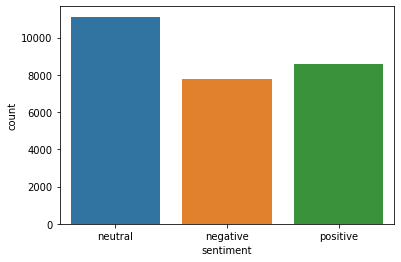

In [17]:
plt.figure()
sns.countplot(x = 'sentiment', data = train)
plt.savefig(os.path.join(fig_path, 'senti_distribution.png'), dpi = 500, bbox_inches = 'tight')

In [18]:
#strip the possible blanks on head and tail
train['text'] = train.apply(lambda x: x['text'].strip(), axis = 1)
train['selected_text'] = train.apply(lambda x: x['selected_text'].strip(), axis = 1)
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",negative


In [19]:
# to see the Jaccard similarity between 'text' and 'selected_text'
def jaccard_score(sent1, sent2):
    words1 = set(sent1.lower().split(' '))
    words2 = set(sent2.lower().split(' '))
    inters = words1.intersection(words2)
    return float(len(inters) / (len(words1) + len(words2) - len(inters)))

In [20]:
train['jaccard_score'] = train.apply(lambda x: jaccard_score(x['text'], x['selected_text']), axis = 1)
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",negative,0.214286


In [21]:
def count_length(sent):
    words = set(sent.split(' '))
    res = len(words)
    return res

In [22]:
train['len_text'] = train.apply(lambda x: count_length(x['text']), axis = 1)
train['len_sel_text'] = train.apply(lambda x: count_length(x['selected_text']), axis = 1)
train.head()

,textID,text,selected_text,sentiment,jaccard_score,len_text,len_sel_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10,2
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5,3
4,358bd9e861,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",negative,0.214286,14,3


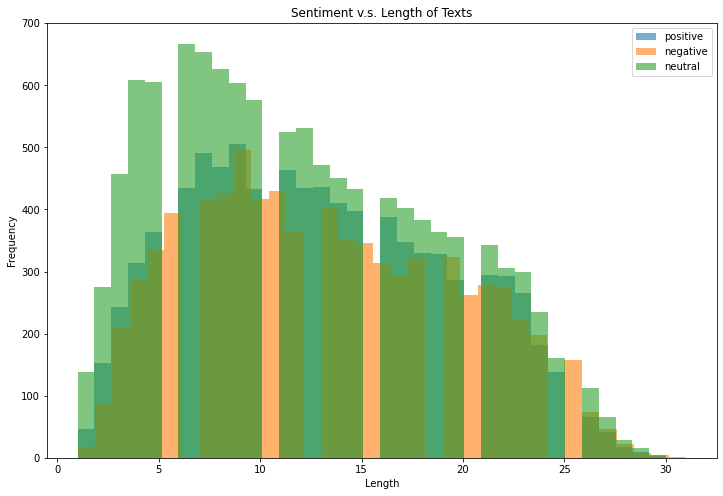

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize = (12,8))
plt.hist(train[ train['sentiment'] == 'positive'].len_text, bins = 35, label = 'positive', alpha=0.6)
plt.hist(train[ train['sentiment'] == 'negative'].len_text, bins = 35, label = 'negative', alpha=0.6)
plt.hist(train[ train['sentiment'] == 'neutral'].len_text, bins = 35, label = 'neutral', alpha=0.6)
plt.legend(loc = 'best')
plt.title('Sentiment v.s. Length of Texts')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()
plt.savefig(os.path.join(fig_path, 'sentiment_length.png'))

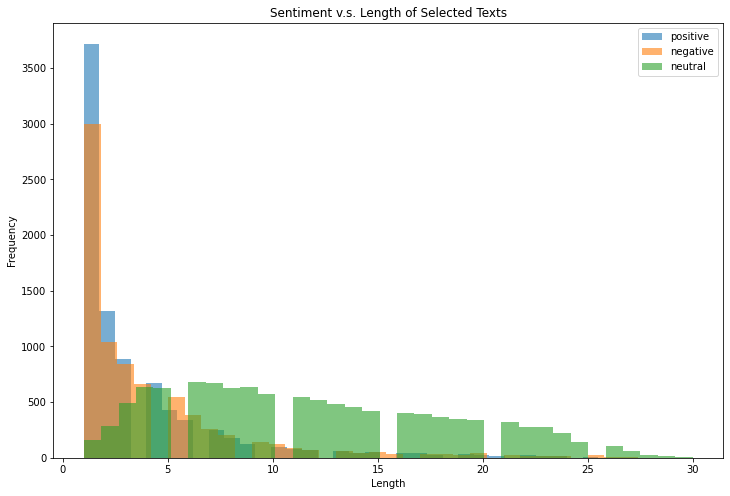

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize = (12,8))
plt.hist(train[ train['sentiment'] == 'positive'].len_sel_text, bins = 35, label = 'positive', alpha=0.6)
plt.hist(train[ train['sentiment'] == 'negative'].len_sel_text, bins = 35, label = 'negative', alpha=0.6)
plt.hist(train[ train['sentiment'] == 'neutral'].len_sel_text, bins = 35, label = 'neutral', alpha=0.6)
plt.legend(loc = 'best')
plt.title('Sentiment v.s. Length of Selected Texts')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()
plt.savefig(os.path.join(fig_path, 'sentiment_sel_length.png'))

In [25]:
train[train['sentiment'] == 'positive'].describe()

,jaccard_score,len_text,len_sel_text
count,8582.000000,8582.000000,8582.000000
mean,0.310905,12.908296,3.500233
std,0.322730,6.346287,4.007822
min,0.000000,1.000000,1.000000
25%,0.076923,8.000000,1.000000
50%,0.166667,12.000000,2.000000
75%,0.416667,18.000000,4.000000
max,1.000000,30.000000,27.000000


In [26]:
train[train['sentiment'] == 'negative'].describe()

,jaccard_score,len_text,len_sel_text
count,7781.000000,7781.000000,7781.000000
mean,0.335344,13.164889,3.923789
std,0.329654,6.395707,4.288111
min,0.000000,1.000000,1.000000
25%,0.083333,8.000000,1.000000
50%,0.200000,13.000000,2.000000
75%,0.470588,18.000000,5.000000
max,1.000000,31.000000,29.000000


In [27]:
train[train['sentiment'] == 'neutral'].describe()

,jaccard_score,len_text,len_sel_text
count,11117.000000,11117.000000,11117.000000
mean,0.975613,12.091841,11.814788
std,0.098793,6.651000,6.592381
min,0.000000,1.000000,1.000000
25%,1.000000,7.000000,6.000000
50%,1.000000,11.000000,11.000000
75%,1.000000,17.000000,17.000000
max,1.000000,30.000000,30.000000


In [28]:
#clean the corpus
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def preprocess(x):
    x = clean_text(x)
    x = remove_punctuations(x)
    return x

In [29]:
train['cleaned_text'] = train['selected_text'].apply(lambda x: clean_text(x))
train.head()


,textID,text,selected_text,sentiment,jaccard_score,len_text,len_sel_text,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10,2,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5,2,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5,3,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",negative,0.214286,14,3,sons of


In [30]:
train['cleaned_text'] = train['cleaned_text'].apply(lambda x: remove_punctuations(x))
train.head()

,textID,text,selected_text,sentiment,jaccard_score,len_text,len_sel_text,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10,2,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5,2,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5,3,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on th...","Sons of ****,",negative,0.214286,14,3,sons of


In [31]:
def get_k_common_words(data, sentiment, k):
    sentiment_df = data[data['sentiment'] == sentiment]
    sent_text_list = sentiment_df['cleaned_text'].tolist()

    #turn the selected text into words:
    words = []
    for sentence in sent_text_list:
        words+=word_tokenize(sentence)

    #remove stopwords
    stop_words = set(stopwords.words('english'))
    words_rmvd = [y.lower() for y in words if y.lower() not in stop_words]

    freq_words = Counter(words_rmvd)
    top_k_common_words = freq_words.most_common(k)

    return top_k_common_words


In [32]:
top_10_positive_words = get_k_common_words(train, 'positive', 10)

In [33]:
print(top_10_positive_words)

[('good', 826), ('happy', 730), ('love', 697), ('day', 456), ('thanks', 439), ('great', 364), ('fun', 287), ('nice', 267), ('mothers', 259), ('hope', 245)]


In [34]:
def plot_top_words(top_words):
    word_freq = {}
    for i in range(len(top_words)):
        word_freq[top_words[i][0]] = int(top_words[i][-1])
    plt.bar(word_freq.keys(), word_freq.values())
    plt.xlabel('Most Common words')
    plt.ylabel('Frequency')
    plt.show()

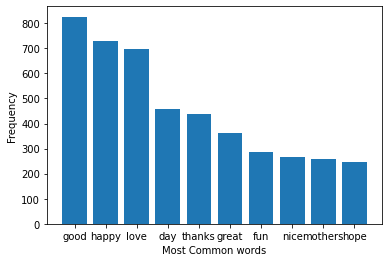

In [35]:
plot_top_words(top_10_positive_words)

[('im', 452), ('miss', 358), ('sad', 343), ('sorry', 300), ('bad', 246), ('hate', 230), ('dont', 221), ('cant', 201), ('sick', 166), ('like', 162)]


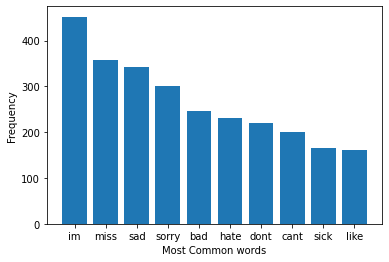

In [36]:
top_10_negative_words = get_k_common_words(train, 'negative', 10)
print(top_10_negative_words)
plot_top_words(top_10_negative_words)

[('im', 1039), ('get', 612), ('go', 569), ('got', 515), ('day', 492), ('dont', 482), ('going', 472), ('work', 467), ('like', 445), ('today', 427)]


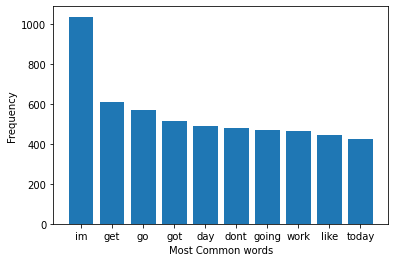

In [37]:
top_10_neutral_words = get_k_common_words(train, 'neutral', 10)
print(top_10_neutral_words)
plot_top_words(top_10_neutral_words)

In [38]:
def plot_word_cloud(text, sentiment, color):
    sentiment_df = train[ train['sentiment'] == sentiment]
    words = ''.join(sentiment_df['selected_text'].tolist())
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white',colormap = color, min_font_size = 10)
    wordcloud.generate(words)

    plt.figure(figsize = (8,8))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
    plt.savefig(os.path.join(fig_path, 'wordcloud'+sentiment+'.png'))

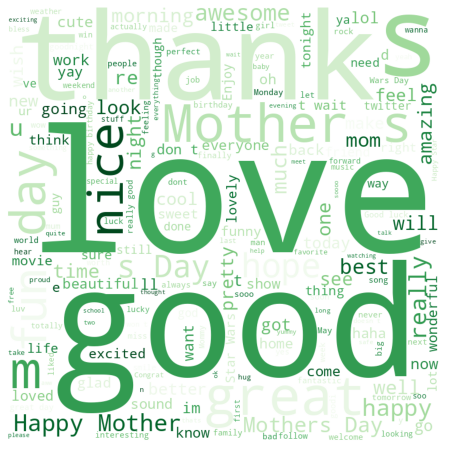

<Figure size 432x288 with 0 Axes>

In [39]:
plot_word_cloud(train, 'positive', "Greens")

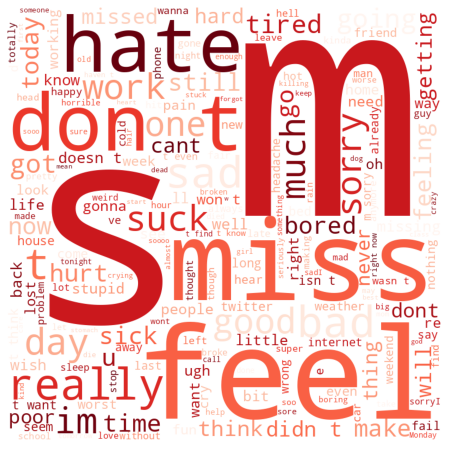

<Figure size 432x288 with 0 Axes>

In [40]:
plot_word_cloud(train, 'negative','Reds')

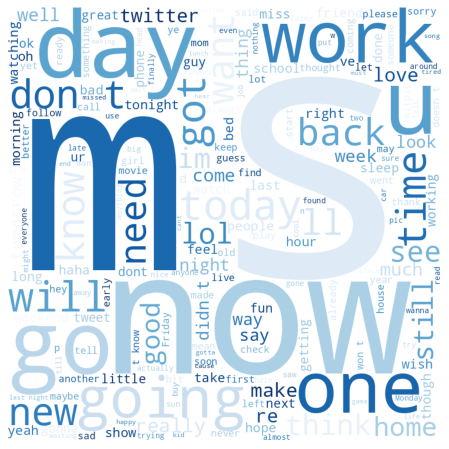

<Figure size 432x288 with 0 Axes>

In [41]:
plot_word_cloud(train, 'neutral','Blues')

In [92]:
train_copy = train.copy()
y_train = train_copy['sentiment']
X_train = train_copy['cleaned_text']
print(y_train)
X_train.head()

0         neutral
1        negative
2        negative
3        negative
4        negative
           ...   
27476    negative
27477    negative
27478    positive
27479    positive
27480     neutral
Name: sentiment, Length: 27480, dtype: object


0    id have responded if i were going
1                             sooo sad
2                          bullying me
3                       leave me alone
4                             sons of 
Name: cleaned_text, dtype: object

In [116]:
train_copy = train.copy()
y_train = train_copy['sentiment']
X_train = train_copy['cleaned_text']
X_train.head()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape,
      X_valid.shape,
      y_train.shape,
      y_valid.shape)

## contrusct a pipeline
pipeline = Pipeline([('vc', CountVectorizer(min_df = 2)),
                     ('tf_idf', TfidfTransformer()),
])
pipeline['vc'].fit(X_train)
train_x = pipeline.fit_transform(X_train)
valid_x = pipeline.transform(X_valid)
print(train_x.shape)
print(valid_x.shape)

(21984,) (5496,) (21984,) (5496,)
(21984, 5723)
(5496, 5723)


In [108]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(train_x, y_train)
acc_train = metrics.accuracy_score(y_train, lr.predict(train_x))
print('accuracy on train data:', acc_train)
y_valid_pred = lr.predict(valid_x)
acc_valid = metrics.accuracy_score(y_valid_pred, y_valid)
print('accuracy on validation data:', acc_valid)

accuracy on train data: 0.8820505822416302
accuracy on validation data: 0.8313318777292577


In [125]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(train_x, y_train)
acc_train = metrics.accuracy_score(y_train, rf.predict(train_x))
print('accuracy on train data:', acc_train)
y_valid_pred = rf.predict(valid_x)
acc_valid = metrics.accuracy_score(y_valid_pred, y_valid)
print('accuracy on validation data:', acc_valid)

accuracy on train data: 0.9827147016011645
accuracy on validation data: 0.8113173216885007


In [128]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [117]:
### A very obvious overfitting occurs###
rf = RandomForestClassifier(random_state = 42, oob_score = True)

params = {'max_depth':[1,3,5,7,9],
          'n_estimators':[10, 20, 50, 80, 100, 150],
          'min_samples_leaf':[1,2,3,4]}

gs_rf = GridSearchCV(rf, param_grid=params, cv = 5)
gs_rf.fit(train_x, y_train)

print(f"Best Leaf Nodes: {gs_rf.best_params_['min_samples_leaf']}")
print(f"Best Number of Tress: {gs_rf.best_params_['n_estimators']}")
print(f"Best Max Depth: {gs_rf.best_params_['max_depth']}")

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

Best Leaf Nodes: 3
Best Number of Tress: 20
Best Max Depth: 9


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [124]:
rf_opt = RandomForestClassifier(
                                n_estimators=gs_rf.best_params_['n_estimators'],
                                min_samples_leaf = gs_rf.best_params_['min_samples_leaf'],oob_score = True)
rf_opt.fit(train_x, y_train)
y_train_pred = rf_opt.predict(train_x)
acc_train = metrics.accuracy_score(y_train_pred, y_train)
print('accuracy on train data:', acc_train)
y_valid_pred = rf_opt.predict(valid_x)
acc_valid = metrics.accuracy_score(y_valid_pred, y_valid)
print('accuracy on validation data:', acc_valid)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


accuracy on train data: 0.7913027656477438
accuracy on validation data: 0.7736535662299855
